In [1]:
import scipy.io
import cv2
from BlockSync2 import *
import numpy as np
import pandas as pd
import scipy.io as io
import pathlib
import os
import sys
from matplotlib import pyplot as plt
import seaborn as sns
from open_ephys import analysis as oea
import bokeh
from bokeh.io import output as b_output
from bokeh.models import formatters
import scipy.signal as sig
from scipy import stats as st
import scipy.interpolate as interp
import time
from scipy.stats import kde
from UtilityFunctions import *

In [4]:
def get_rising_falling_edges(bool_vec):
    """
    Use this function to understand the rising and falling edges of True/False transitions in bool_vec
    :param bool_vec: some boolean vector describing a condition in the data, for example: df['col_name'].values > threshold
    :return: Rising and falling boolean vectors for epochs where condition is True
    """
    bool_vec = bool_vec.astype(int)
    shift_vec = np.insert(bool_vec[0:-1],0,0).astype(int)
    condition_vec = np.subtract(bool_vec,shift_vec)
    rising_edges = condition_vec == 1
    falling_edges = condition_vec == -1
    return rising_edges, falling_edges

def collect_condition_samples(block,sync_ttls,cond_boolean, data,timestamps):
    """
    For each condition vector inside a block use this function to collect a dataframe with the samples of interest according to the boolean condition
    :param block: a BlockSync object
    :param sync_ttls: The synchronized timestamps associated with the conditional dataframe
    :param cond_boolean: a boolean indicating which timestamps are of interest
    :param data: EP samples
    :param timestamps:EP timestamps
    :return: cdf is a dataframe with the relevant samples for each segment
    """
    rising, falling = get_rising_falling_edges(cond_boolean)
    rising_ttls = sync_ttls[rising].values
    falling_ttls = sync_ttls[falling].values
    # create a "conition" DataFrame
    cdf = pd.DataFrame(data=np.array([rising_ttls, falling_ttls, falling_ttls - rising_ttls]).T,columns=['rising','falling','length'])
    min_length = block.sample_rate
    # treat too short segments
    for ind in range(len(cdf)):
        if cdf.loc[ind,'length'] >= min_length:
            continue
        else:
            mid_ttl = np.floor(np.mean([cdf.loc[ind, 'rising'],cdf.loc[ind,'falling']])).astype(int)
            cdf.at[ind,'rising'] = mid_ttl - min_length//2
            cdf.at[ind,'falling'] = mid_ttl + min_length//2
            cdf.at[ind,'length'] = (mid_ttl + min_length//2) - (mid_ttl - min_length//2)

    cdf.insert(loc=3,column='samples',value=np.nan)
    cdf['samples'] = cdf['samples'].astype(object)
    # go over the dataframe:
    for ind in tqdm(range(len(cdf))):
        # understand the TTls indices:
        rising_ind = np.where(timestamps == cdf.loc[ind,'rising'])[0][0]
        falling_ind = np.where(timestamps == cdf.loc[ind,'falling'])[0][0]
        seg_samples = data[range(rising_ind, falling_ind)]
        cdf.at[ind,'samples']=seg_samples
    cdf['block'] = block.block_num

    return cdf

def collect_condition_PSDs_single_block_old(block,sync_ttls,cond_boolean, data,timestamps):
    """
    For each condition vector inside a block use this function to collect a dataframe with the samples of interest according to the boolean condition
    :param block: a BlockSync object
    :param sync_ttls: The synchronized timestamps associated with the conditional dataframe
    :param cond_boolean: a boolean indicating which timestamps are of interest
    :param data: EP samples
    :param timestamps:EP timestamps
    :return: cdf is a dataframe with the relevant samples for each segment
    """
    rising, falling = get_rising_falling_edges(cond_boolean)
    rising_ttls = sync_ttls[rising].values
    falling_ttls = sync_ttls[falling].values
    # create a "conition" DataFrame
    cdf = pd.DataFrame(data=np.array([rising_ttls, falling_ttls, falling_ttls - rising_ttls]).T,columns=['rising','falling','length'])
    min_length = block.sample_rate
    # treat too short segments
    for ind in tqdm(range(len(cdf))):
        if cdf.loc[ind,'length'] >= min_length:
            continue
        else:
            mid_ttl = np.floor(np.mean([cdf.loc[ind, 'rising'],cdf.loc[ind,'falling']])).astype(int)
            cdf.at[ind,'rising'] = mid_ttl - min_length//2
            cdf.at[ind,'falling'] = mid_ttl + min_length//2
            cdf.at[ind,'length'] = (mid_ttl + min_length//2) - (mid_ttl - min_length//2)

    #cdf.insert(loc=3,column='samples',value=np.nan)
    #cdf['samples'] = cdf['samples'].astype(object)
    cdf.insert(loc=3,column='fs',value=np.nan)
    cdf['fs'] = cdf['fs'].astype(object)
    cdf.insert(loc=3,column='pxx',value=np.nan)
    cdf['pxx'] = cdf['pxx'].astype(object)
    # go over the dataframe:
    for ind in tqdm(range(len(cdf))):
        # understand the TTls indices:
        rising_ind = np.where(timestamps == cdf.loc[ind,'rising'])[0][0]
        falling_ind = np.where(timestamps == cdf.loc[ind,'falling'])[0][0]
        seg_samples = data[range(rising_ind, falling_ind)]
        fs, pxx = sig.welch(seg_samples,block.sample_rate,nperseg=8192,return_onesided=True)
        cdf.at[ind,'pxx'] = pxx
        cdf.at[ind,'fs'] = fs
        #cdf.at[ind,'samples']=seg_samples
    cdf['block'] = block.block_num

    return cdf

def collect_condition_PSDs_single_block(block,sync_ttls,cond_boolean, data,timestamps):
    """
    For each condition vector inside a block use this function to collect a dataframe with the samples of interest according to the boolean condition
    :param block: a BlockSync object
    :param sync_ttls: The synchronized timestamps associated with the conditional dataframe
    :param cond_boolean: a boolean indicating which timestamps are of interest
    :param data: EP samples
    :param timestamps:EP timestamps
    :return: cdf is a dataframe with the relevant samples for each segment
    """
    rising, falling = get_rising_falling_edges(cond_boolean)
    rising_ttls = sync_ttls[rising].values
    falling_ttls = sync_ttls[falling].values
    # create a "conition" DataFrame
    cdf = pd.DataFrame(data=np.array([rising_ttls, falling_ttls, falling_ttls - rising_ttls]).T,columns=['rising','falling','length'])
    min_length = block.sample_rate
    # treat too short segments
    for ind in tqdm(range(len(cdf))):
        if cdf.loc[ind,'length'] >= min_length:
            continue
        else:
            mid_ttl = np.floor(np.mean([cdf.loc[ind, 'rising'],cdf.loc[ind,'falling']])).astype(int)
            cdf.at[ind,'rising'] = mid_ttl - min_length//2
            cdf.at[ind,'falling'] = mid_ttl + min_length//2
            cdf.at[ind,'length'] = (mid_ttl + min_length//2) - (mid_ttl - min_length//2)

    #cdf.insert(loc=3,column='samples',value=np.nan)
    #cdf['samples'] = cdf['samples'].astype(object)
    cdf.insert(loc=3,column='fs',value=np.nan)
    cdf['fs'] = cdf['fs'].astype(object)
    cdf.insert(loc=3,column='pxx',value=np.nan)
    cdf['pxx'] = cdf['pxx'].astype(object)
    cdf.insert(loc=3,column='samples',value=np.nan)
    cdf['samples'] = cdf['samples'].astype(object)
    # go over the dataframe:
    for ind in tqdm(range(len(cdf))):
        # understand the TTls indices:
        rising_ind = np.where(timestamps == cdf.loc[ind,'rising'])[0][0]
        falling_ind = np.where(timestamps == cdf.loc[ind,'falling'])[0][0]
        seg_samples = data[range(rising_ind, falling_ind)]
        fs, pxx = sig.welch(seg_samples,block.sample_rate,nperseg=8192,return_onesided=True)
        cdf.at[ind,'pxx'] = pxx
        cdf.at[ind,'fs'] = fs
        cdf.at[ind,'samples']=seg_samples
    cdf['block'] = block.block_num

    return cdf

In [ ]:
# create a list of blocks to run the analysis on
# To generate the blocks:
block_numbers = [i for i in range(6,27)]
bad_blocks = [1,2,3,4,5,8,10,22]
blocklist = block_generator(block_numbers,pathlib.Path(r"Z:\Nimrod\experiments"),'PV_24',bad_blocks=bad_blocks)
for block in blocklist:
    analyzed_block_automated_pipe(block)
    block.calibrate_pixel_size(10)

In [4]:
# for each block, collect pupil diameter values over time and calculate STD -
# Sort the timestamps into three groups of segments - above z-score 2, below z-score -2 and between
# segment lengths should be at least long enough to get information about the low frequencies

In [143]:
# define z score threshold for large / small pupil
upper_threshold = 1
mid_window = (-0.05,0.05)
low_window = (-2.5,-1)
blinks_thr = -3
# for a single block, collect pupil diameter values over time
block = blocklist[0]
if sum(block.re_df['Arena_TTL'] == block.le_df['Arena_TTL']) == len(block.re_df): # check that timestamps are actually aligned
    df = block.le_df[['Arena_TTL','ms_axis']] # create a dataframe with joint Arena_TTL vector as EP identifier

    df.insert(loc=1,column='block_num',value=block.block_num) # keep block numbers for later

    # get right eye pupil area values
    right_vals = (block.re_df['ellipse_size']*block.R_pix_size).values
    z_right = (right_vals - np.nanmean(right_vals)) / np.nanstd(right_vals)

    # get left eye values
    left_vals = (block.le_df['ellipse_size']*block.L_pix_size).values
    z_left = (left_vals - np.nanmean(left_vals)) / np.nanstd(left_vals)

    df.insert(loc=1,column='re_pupil_z',value=z_right)
    df.insert(loc=1,column='le_pupil_z',value=z_left)

    # create the conditionals to look for:
    r_high = df['re_pupil_z'].values > upper_threshold
    l_high = df['le_pupil_z'].values > upper_threshold

    r_low = (df['re_pupil_z'].values > low_window[0]) & (df['re_pupil_z'].values < low_window[1])
    l_low = (df['le_pupil_z'].values > low_window[0]) & (df['le_pupil_z'].values < low_window[1])

    r_mid = (df['re_pupil_z'].values > mid_window[0]) & (df['re_pupil_z'].values < mid_window[1])
    l_mid = (df['le_pupil_z'].values > mid_window[0]) & (df['le_pupil_z'].values < mid_window[1])



In [ ]:

# define conditionals:
upper_threshold = 1.5
upper_mids = (1,1.5)
lower_mids = (-1,-1.5)
low_window = (-3,-1.5)
mid_window = (-0.05,0.05)

# get the all dataframes initialized:
all_r_high = pd.DataFrame(columns=['rising','falling','length','samples','block'])
all_l_high = pd.DataFrame(columns=['rising','falling','length','samples','block'])
all_r_low = pd.DataFrame(columns=['rising','falling','length','samples','block'])
all_l_low = pd.DataFrame(columns=['rising','falling','length','samples','block'])
all_l_mid = pd.DataFrame(columns=['rising','falling','length','samples','block'])
all_r_mid = pd.DataFrame(columns=['rising','falling','length','samples','block'])
all_r_upper_mid = pd.DataFrame(columns=['rising','falling','length','samples','block'])
all_l_upper_mid = pd.DataFrame(columns=['rising','falling','length','samples','block'])
all_l_lower_mid = pd.DataFrame(columns=['rising','falling','length','samples','block'])
all_r_lower_mid = pd.DataFrame(columns=['rising','falling','length','samples','block'])

# go block by block and collect conditionals
for block in blocklist:
    # get all the electrophysiology data of a single electrode:
    print(f'getting EP data from block {block.block_num}')
    session = oea.Session(str(block.oe_path.parent))
    data = session.recordnodes[0].recordings[0].continuous[0].samples[:,17]
    timestamps = session.recordnodes[0].recordings[0].continuous[0].timestamps
    print('done')

    if sum(block.re_df['Arena_TTL'] == block.le_df['Arena_TTL']) == len(block.re_df): # check that timestamps are actually aligned and nothing freaky happened
        df = block.le_df[['Arena_TTL','ms_axis']] # create a dataframe with joint Arena_TTL vector as EP identifier

        df.insert(loc=1,column='block_num',value=block.block_num) # keep block numbers for later

        # get right eye pupil area values
        right_vals = (block.re_df['ellipse_size']*block.R_pix_size).values
        z_right = (right_vals - np.nanmean(right_vals)) / np.nanstd(right_vals)

        # get left eye values
        left_vals = (block.le_df['ellipse_size']*block.L_pix_size).values
        z_left = (left_vals - np.nanmean(left_vals)) / np.nanstd(left_vals)

        df.insert(loc=1,column='re_pupil_z',value=z_right)
        df.insert(loc=1,column='le_pupil_z',value=z_left)

        # create the conditionals to look for:
        r_high = df['re_pupil_z'].values > upper_threshold
        l_high = df['le_pupil_z'].values > upper_threshold

        r_upper_mid = (df['re_pupil_z'].values > upper_mids[0]) & (df['re_pupil_z'].values < upper_mids[1])
        l_upper_mid = (df['le_pupil_z'].values > upper_mids[0]) & (df['le_pupil_z'].values < upper_mids[1])

        r_lower_mid = (df['re_pupil_z'].values < lower_mids[0]) & (df['re_pupil_z'].values > lower_mids[1])
        l_lower_mid = (df['le_pupil_z'].values < lower_mids[0]) & (df['le_pupil_z'].values > lower_mids[1])


        r_low = (df['re_pupil_z'].values > low_window[0]) & (df['re_pupil_z'].values < low_window[1])
        l_low = (df['le_pupil_z'].values > low_window[0]) & (df['le_pupil_z'].values < low_window[1])

        r_mid = (df['re_pupil_z'].values > mid_window[0]) & (df['re_pupil_z'].values < mid_window[1])
        l_mid = (df['le_pupil_z'].values > mid_window[0]) & (df['le_pupil_z'].values < mid_window[1])

        print('computing PSDs for each segment')
        synced_ttls = df['Arena_TTL']
        r_high_df = collect_condition_PSDs_single_block(block=block,sync_ttls=synced_ttls,cond_boolean=r_high,data=data,timestamps=timestamps)
        all_r_high = pd.concat([all_r_high, r_high_df])
        l_high_df = collect_condition_PSDs_single_block(block=block,sync_ttls=synced_ttls,cond_boolean=l_high,data=data,timestamps=timestamps)
        all_l_high = pd.concat([all_l_high, l_high_df])
        r_low_df = collect_condition_PSDs_single_block(block=block,sync_ttls=synced_ttls,cond_boolean=r_low,data=data,timestamps=timestamps)
        all_r_low = pd.concat([all_r_low, r_low_df])
        l_low_df = collect_condition_PSDs_single_block(block=block,sync_ttls=synced_ttls,cond_boolean=l_low,data=data,timestamps=timestamps)
        all_l_low = pd.concat([all_l_low, l_low_df])
        l_mid_df = collect_condition_PSDs_single_block(block=block,sync_ttls=synced_ttls,cond_boolean=l_mid,data=data,timestamps=timestamps)
        all_l_mid = pd.concat([all_l_mid,l_mid_df])
        r_mid_df = collect_condition_PSDs_single_block(block=block,sync_ttls=synced_ttls,cond_boolean=r_mid,data=data,timestamps=timestamps)
        all_r_mid = pd.concat([all_r_mid,r_mid_df])
        r_upper_mid_df = collect_condition_PSDs_single_block(block=block,sync_ttls=synced_ttls,cond_boolean=r_upper_mid,data=data,timestamps=timestamps)
        all_r_upper_mid = pd.concat([all_r_upper_mid,r_upper_mid_df])
        l_upper_mid_df = collect_condition_PSDs_single_block(block=block,sync_ttls=synced_ttls,cond_boolean=l_upper_mid,data=data,timestamps=timestamps)
        all_l_upper_mid = pd.concat([all_l_upper_mid,l_upper_mid_df])
        l_lower_mid_df = collect_condition_PSDs_single_block(block=block,sync_ttls=synced_ttls,cond_boolean=l_lower_mid,data=data,timestamps=timestamps)
        all_l_lower_mid = pd.concat([all_l_lower_mid,l_lower_mid_df])
        r_lower_mid_df = collect_condition_PSDs_single_block(block=block,sync_ttls=synced_ttls,cond_boolean=r_lower_mid,data=data,timestamps=timestamps)
        all_r_lower_mid = pd.concat([all_r_lower_mid,r_lower_mid_df])

    del data

In [9]:

synced_ttls = df['Arena_TTL']
r_high_df = collect_condition_samples(block=block,sync_ttls=synced_ttls,cond_boolean=r_high,data=data,timestamps=timestamps)
l_high_df = collect_condition_samples(block=block,sync_ttls=synced_ttls,cond_boolean=l_high,data=data,timestamps=timestamps)
r_low_df = collect_condition_samples(block=block,sync_ttls=synced_ttls,cond_boolean=r_low,data=data,timestamps=timestamps)
l_low_df = collect_condition_samples(block=block,sync_ttls=synced_ttls,cond_boolean=l_low,data=data,timestamps=timestamps)



In [ ]:
# Try the imagescale graph here !!!
# Set the different conditions into a dictionary for reference
df_dict = {
    'r_high':   all_r_high,
    'r_low':    all_r_low,
    'l_high':   all_l_high,
    'l_low':    all_l_low,
    'l_mid':    all_l_mid,
    'r_mid':    all_r_mid,
    'r_upper_mid': all_r_upper_mid,
    'l_upper_mid': all_l_upper_mid,
    'r_lower_mid': all_r_lower_mid,
    'l_lower_mid': all_l_lower_mid,
}


In [ ]:
# Samples based pxx calculation + mean calculation
df_dict = {
    'r_high':   all_r_high,
    'r_low':    all_r_low,
    'l_high':   all_l_high,
    'l_low':    all_l_low,
    'l_mid':    all_l_mid,
    'r_mid':    all_r_mid
}
mean_dict = {
    'r_high':   [],
    'r_low':    [],
    'l_high':   [],
    'l_low':    [],
    'l_mid':    [],
    'r_mid':    []

}

for condition in mean_dict.keys():
    print(f'working on condition={condition}')
    cdf = df_dict[condition]
    if 'fs' not in cdf.columns.values:
        cdf.insert(loc=4,column='fs',value=np.nan)
        cdf.insert(loc=5,column='pxx',value=np.nan)


    cdf['pxx'] = cdf['pxx'].astype(object)
    cdf['fs'] = cdf['fs'].astype(object)
    # go over the dataframe and append a fs pxx columns
    for ind in tqdm(range(len(cdf))):
        samples = cdf.iloc[ind]['samples']
        fs, pxx = sig.welch(samples,block.sample_rate,nperseg=8192,return_onesided=True)
        cdf.iat[ind,4] = fs
        cdf.iat[ind,5] = pxx
    pxx_mean = np.mean(np.vstack([cdf['pxx'].values][0]),axis=0)
    df_dict[condition]  = cdf
    mean_dict[condition].append(pxx_mean)
    mean_dict[condition].append(fs)


In [ ]:
# PSD based calculation
df_dict = {
    'r_high':   all_r_high,
    'r_low':    all_r_low,
    'l_high':   all_l_high,
    'l_low':    all_l_low,
    'l_mid':    all_l_mid,
    'r_mid':    all_r_mid,
    'r_upper_mid': all_r_upper_mid,
    'l_upper_mid': all_l_upper_mid,
    'r_lower_mid': all_r_lower_mid,
    'l_lower_mid': all_l_lower_mid,
}
mean_dict = {
    'r_high':   [],
    'r_low':    [],
    'l_high':   [],
    'l_low':    [],
    'l_mid':    [],
    'r_mid':    [],
    'r_upper_mid':[],
    'l_upper_mid':[],
    'r_lower_mid':[],
    'l_lower_mid':[]
}
for condition in mean_dict.keys():
    print(f'working on condition={condition}')
    cdf = df_dict[condition]
    pxx_mean = np.mean(np.vstack([cdf['pxx'].values][0]),axis=0)
    mean_dict[condition].append(pxx_mean)
    mean_dict[condition].append(cdf['fs'].iloc[0])

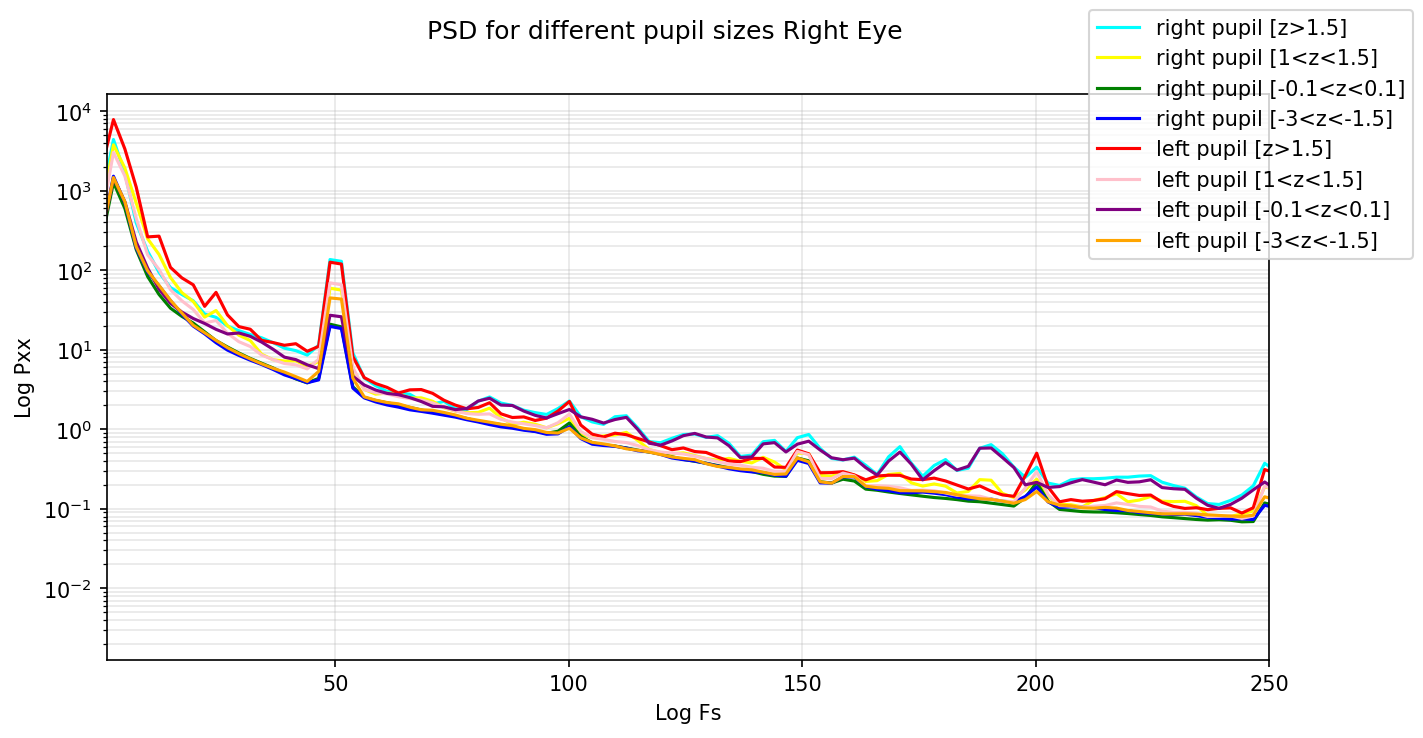

In [31]:
r_high_pxx = mean_dict['r_high'][0]
l_high_pxx = mean_dict['l_high'][0]
r_low_pxx = mean_dict['r_low'][0]
l_low_pxx = mean_dict['l_low'][0]
l_mid_pxx = mean_dict['l_mid'][0]
r_mid_pxx = mean_dict['r_mid'][0]
r_upper_mid_pxx = mean_dict['r_upper_mid'][0]
l_upper_mid_pxx = mean_dict['l_upper_mid'][0]
fs = mean_dict['r_low'][1]

fig, ax = plt.subplots(figsize=(10,5),dpi=150)
#plt.xscale('log')
ax.set_xlim(1,250)
plt.yscale('log')
ax.plot(fs,r_high_pxx,color='cyan',label='right pupil [z>1.5]')
ax.plot(fs,r_upper_mid_pxx,color='yellow',label='right pupil [1<z<1.5]')
ax.plot(fs,r_mid_pxx,color='green',label='right pupil [-0.1<z<0.1]')
ax.plot(fs,r_low_pxx,color='blue',label='right pupil [-3<z<-1.5]')

ax.plot(fs,l_high_pxx,color='red',label='left pupil [z>1.5]')
ax.plot(fs,l_upper_mid_pxx,color='pink',label='left pupil [1<z<1.5]')
ax.plot(fs,l_mid_pxx,color='purple',label='left pupil [-0.1<z<0.1]')
ax.plot(fs,l_low_pxx,color='orange',label='left pupil [-3<z<-1.5]')


ax.set_xlabel('Log Fs')
ax.set_ylabel('Log Pxx')
#ax.set_xlim(2,50)
fig.legend()
fig.suptitle('PSD for different pupil sizes Right Eye ')
ax.grid(which='both',axis='both',alpha=0.3)
#plt.savefig(r'D:\MarkS3\Pictures\Graphs\PSD_pupilDiameter_BothEyes.png')

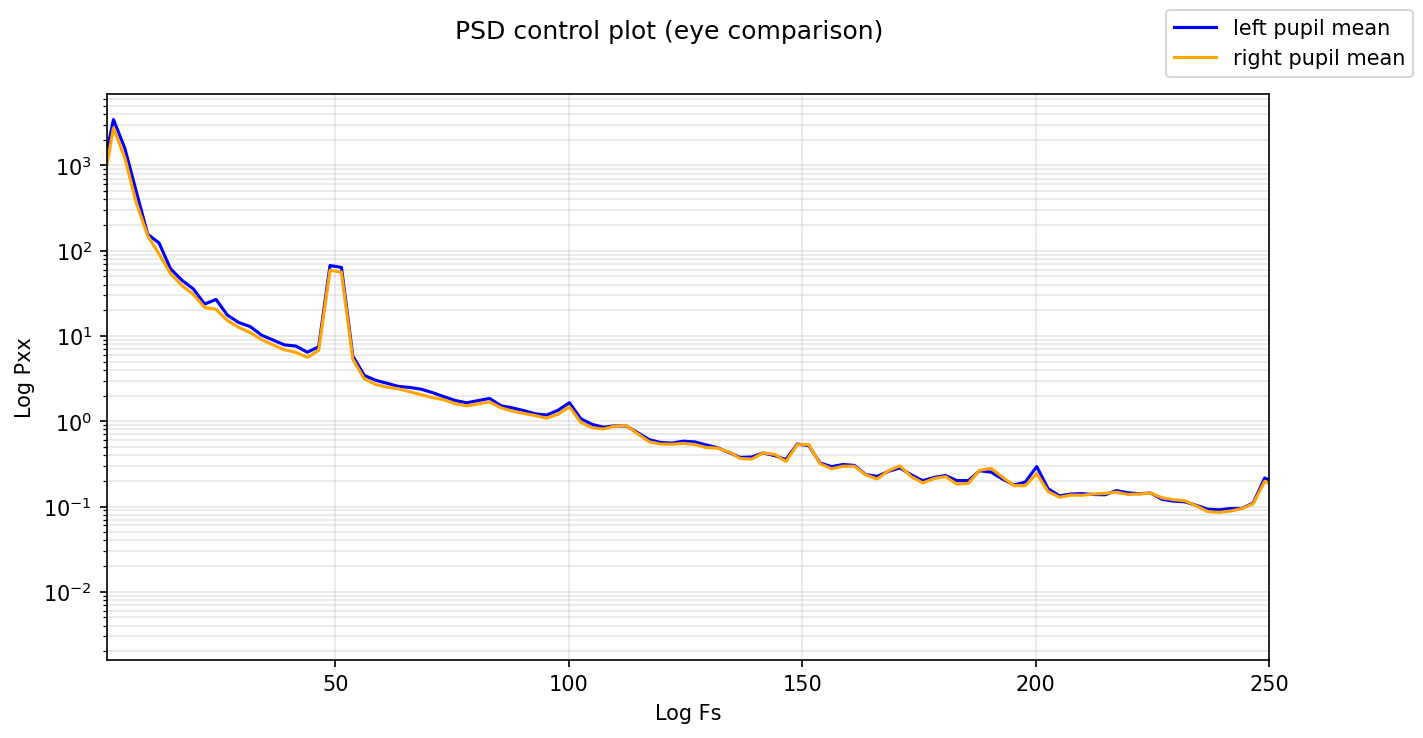

In [29]:
r_high_pxx = mean_dict['r_high'][0]
l_high_pxx = mean_dict['l_high'][0]
r_low_pxx = mean_dict['r_low'][0]
l_low_pxx = mean_dict['l_low'][0]
l_mid_pxx = mean_dict['l_mid'][0]
r_mid_pxx = mean_dict['r_mid'][0]
r_upper_mid_pxx = mean_dict['r_upper_mid'][0]
l_upper_mid_pxx = mean_dict['l_upper_mid'][0]
r_mean = np.mean(np.vstack([r_low_pxx,r_mid_pxx,r_upper_mid_pxx,r_high_pxx]),axis=0)
l_mean = np.mean(np.vstack([l_low_pxx,l_mid_pxx,l_upper_mid_pxx,l_high_pxx]),axis=0)
fs = mean_dict['r_low'][1]

fig, ax = plt.subplots(figsize=(10,5),dpi=150)
#plt.xscale('log')
ax.set_xlim(1,250)
plt.yscale('log')
# ax.plot(fs,r_high_pxx,color='cyan',label='right pupil [z>1.5]')
# ax.plot(fs,r_upper_mid_pxx,color='yellow',label='right pupil [1<z<1.5]')
# ax.plot(fs,r_mid_pxx,color='green',label='right pupil [-0.1<z<0.1]')
# ax.plot(fs,r_low_pxx,color='blue',label='right pupil [-3<z<-1.5]')
ax.plot(fs,l_mean,color='blue',label='left pupil mean')
ax.plot(fs,r_mean,color='orange',label='right pupil mean')
# ax.plot(fs,l_high_pxx,color='red',label='left pupil [z>1.5]')
# ax.plot(fs,l_upper_mid_pxx,color='pink',label='left pupil [1<z<1.5]')
# ax.plot(fs,l_mid_pxx,color='purple',label='left pupil [-0.1<z<0.1]')
# ax.plot(fs,l_low_pxx,color='orange',label='left pupil [-3<z<-1.5]')


ax.set_xlabel('Log Fs')
ax.set_ylabel('Log Pxx')
#ax.set_xlim(2,50)
fig.legend()
fig.suptitle('PSD control plot (eye comparison)')
ax.grid(which='both',axis='both',alpha=0.3)
#plt.savefig(r'D:\MarkS3\Pictures\Graphs\PSD_pupilDiameter_eye_means_as_control.png')

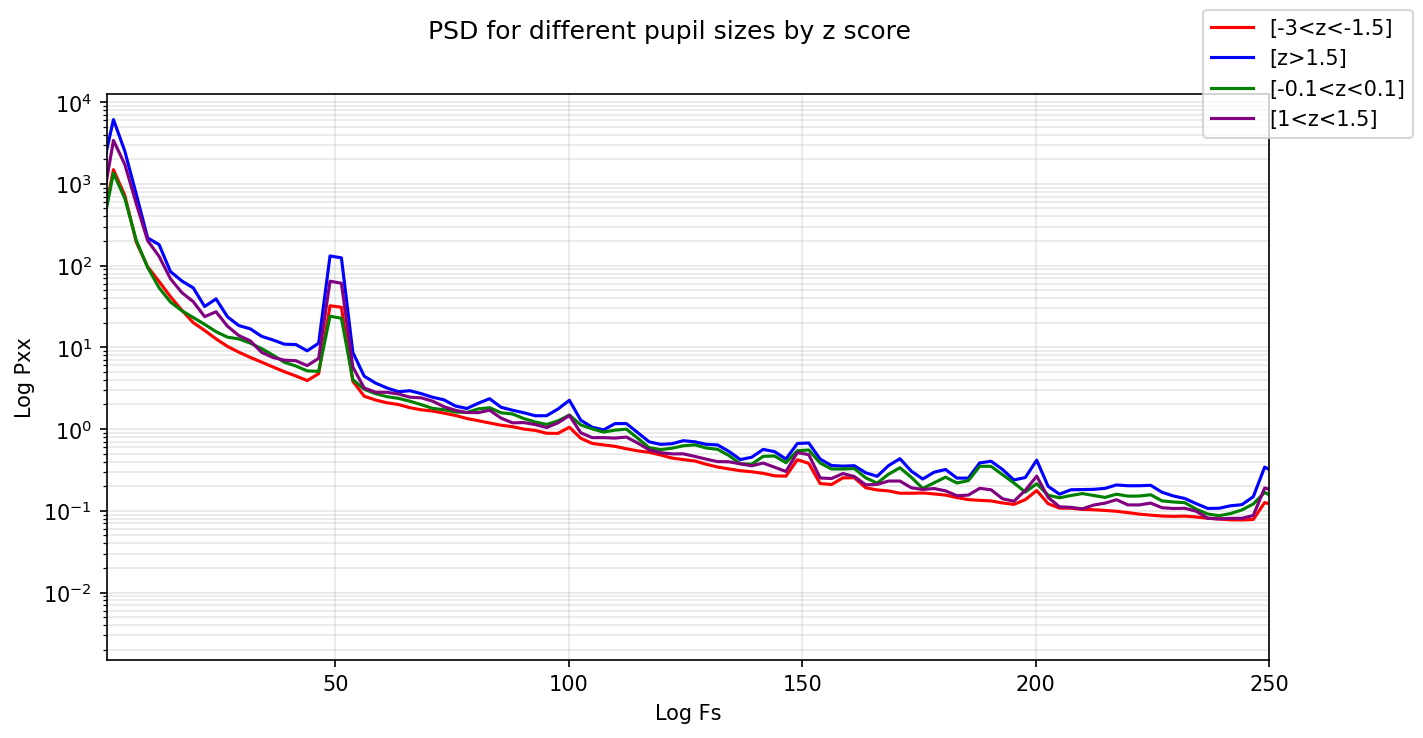

In [28]:

r_high_pxx = mean_dict['r_high'][0]
l_high_pxx = mean_dict['l_high'][0]
r_low_pxx = mean_dict['r_low'][0]
l_low_pxx = mean_dict['l_low'][0]
l_mid_pxx = mean_dict['l_mid'][0]
r_mid_pxx = mean_dict['r_mid'][0]
r_upper_mid_pxx = mean_dict['r_upper_mid'][0]
l_upper_mid_pxx = mean_dict['l_upper_mid'][0]

low_mean = np.mean(np.vstack([l_low_pxx,r_low_pxx]),axis=0)
high_mean = np.mean(np.vstack([l_high_pxx,r_high_pxx]),axis=0)
mid_mean = np.mean(np.vstack([l_mid_pxx,r_mid_pxx]),axis=0)
upper_mid_mean = np.mean(np.vstack([r_upper_mid_pxx,l_upper_mid_pxx]),axis=0)

fs = mean_dict['r_low'][1]

fig, ax = plt.subplots(figsize=(10,5),dpi=150)
#plt.xscale('log')
ax.set_xlim(1,250)
plt.yscale('log')
ax.plot(fs,low_mean,color='red',label='[-3<z<-1.5]')
ax.plot(fs,high_mean,color='blue',label='[z>1.5]')
ax.plot(fs,mid_mean,color='green',label='[-0.1<z<0.1]')
ax.plot(fs,upper_mid_mean,color='purple',label='[1<z<1.5]')

ax.grid(which='both',axis='both',alpha=0.3)
ax.set_xlabel('Log Fs')
ax.set_ylabel('Log Pxx')
#ax.set_xlim(2,50)
fig.legend()
fig.suptitle('PSD for different pupil sizes by z score')
#plt.savefig(r'D:\MarkS3\Pictures\Graphs\PSD_pupilDiameter_z_scores.png')

In [121]:
np.vstack([l_low_pxx,r_low_pxx])

array([[2.71308454e+02, 1.32401554e+03, 6.93261370e+02, ...,
        3.18312278e-03, 3.96755102e-03, 3.21843188e-03],
       [5.33221758e+02, 2.85848074e+03, 1.96978958e+03, ...,
        3.34178380e-03, 4.11809024e-03, 3.23935987e-03]])

(0.0, 50.0)

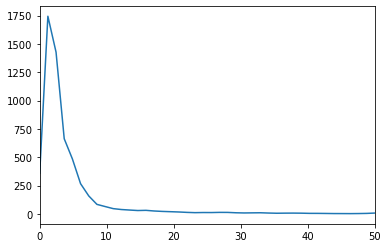

In [35]:
pxx_mean = np.mean(np.vstack([cdf['pxx'].values][0]),axis=0)
plt.plot(fs,pxx_mean)
plt.xlim(0,50)
#np.vstack(cdf['pxx'])

In [272]:
# Construct a function that gets a condition's boolean and returns equal length segments of the block for PSD analysis
r_high_rising, r_high_falling = get_rising_falling_edges(r_high)
rising_ttls = df['Arena_TTL'][r_high_rising].values
falling_ttls = df['Arena_TTL'][r_high_falling].values
# create a "conition" DataFrame
cdf = pd.DataFrame(data=np.array([rising_ttls, falling_ttls, falling_ttls - rising_ttls]).T,columns=['rising','falling','length'])
min_length = 20000
# treat too short segments
for ind in range(len(cdf)):
    if cdf.loc[ind,'length'] >= min_length:
        continue
    else:
        mid_ttl = np.floor(np.mean([cdf.loc[ind, 'rising'],cdf.loc[ind,'falling']])).astype(int)
        cdf.at[ind,'rising'] = mid_ttl - min_length//2
        cdf.at[ind,'falling'] = mid_ttl + min_length//2
        cdf.at[ind,'length'] = (mid_ttl + min_length//2) - (mid_ttl - min_length//2)

# get all the electrophysiology data of a single electrode:
print(f'getting EP data from block {block.block_num}')
session = oea.Session(str(block.oe_path.parent))
data = session.recordnodes[0].recordings[0].continuous[0].samples[:,17]
timestamps = session.recordnodes[0].recordings[0].continuous[0].timestamps
print('done')


cdf.insert(loc=3,column='samples',value=np.nan)
cdf['samples'] = cdf['samples'].astype(object)
# go over the dataframe:
for ind in range(len(cdf)):
    # understand the TTls indices:
    rising_ind = np.where(timestamps == cdf.loc[ind,'rising'])[0][0]
    falling_ind = np.where(timestamps == cdf.loc[ind,'falling'])[0][0]
    seg_samples = data[range(rising_ind, falling_ind)]
    cdf.at[ind,'samples']=seg_samples





getting EP data from block 006
done


In [273]:
#cdf.insert(loc=3,column='samples',value=np.nan)
block.sampl

,rising,falling,length,samples
0,9266005.0,9286005.0,20000.0,"[-41.730000000000004, -32.955, -47.58, -46.995..."
1,9267711.0,9287711.0,20000.0,"[66.69, 66.495, 70.785, 82.095, 74.685, 70.59,..."
2,9475033.0,9495033.0,20000.0,"[-180.57, -174.33, -186.81, -193.05, -186.4200..."
3,9478617.0,9498617.0,20000.0,"[100.425, 101.4, 82.29, 79.56, 89.505000000000..."
4,9491518.0,9551254.0,59736.0,"[73.125, 64.935, 73.32000000000001, 55.575, 58..."
...,...,...,...,...
401,19001115.0,19021115.0,20000.0,"[9.165000000000001, 17.94, 11.115, -0.78, 0.19..."
402,20435992.0,20455992.0,20000.0,"[74.88, 74.685, 71.175, 75.66, 65.52, 65.91, 7..."
403,20437186.0,20457186.0,20000.0,"[5.46, -2.9250000000000003, -2.73, 3.315, 9.55..."
404,21240198.0,21260198.0,20000.0,"[-105.3, -113.685, -108.81, -123.2400000000000..."


(array([   36.,    66.,    90.,   174.,   673.,  5590., 27458., 23392.,
        13498.,   769.]),
 array([-7.4105964 , -6.36802664, -5.32545688, -4.28288712, -3.24031736,
        -2.1977476 , -1.15517784, -0.11260808,  0.92996168,  1.97253144,
         3.0151012 ]),
 <a list of 10 Patch objects>)

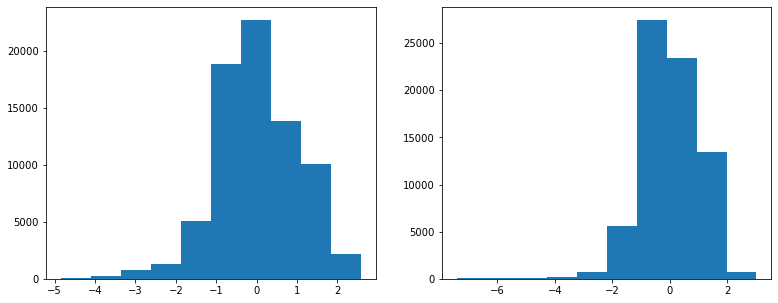

In [190]:
fig,ax = plt.subplots(ncols=2,figsize = (13,5))
ax[0].hist(df['le_pupil_z'])
ax[1].hist(df['re_pupil_z'])

In [192]:
# get the timestamps for where the pupil diameter is either larger / smaller than 2 stds:
upper_t = 1.5


In [194]:
# build a segmentation function here
above_boolean = (df['le_pupil_z'].values > upper_t and df['re_pupil_z'] > upper_t).astype(int)
rising_edges,falling_edges = get_rising_falling_edges(above_boolean)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()